### Question 1
  
For each of the following distributions, give an example of data that you would expect to follow this distribution (besides the examples already discussed in class).  
  
**a.Binomial**  
  
Suppose there is a free lunch event every Friday after 6501 class for the students who registered this class. We assume the probability for a student of attending the event is p, and probability of not attending is (1-p). The value of p is constant in all weeks for all students. And each student's decision will not be influenced by other students and by whether or not he attended before. Under such conditions, the number of students who attend the free lunch event each time will follow the bnomial distribution.  
  
  
**b.Geometric**  
  
For a player who is playing a FPS(First-person shooting) video game, the probabilty of one shot that hits the enemy is p and the probabilty is independent and constant in each shot. So the probability of hitting the enemy for the first time after n times of failures will follow the geometric distribution.  
  
  
**c.Poisson**  
  
Suppose the average number of infants born in a hospital in a given period of time is m. And baby born is independent and identically distributed. Then the actual number of infants born in that hospital within the same length of time period will follow poisson distribution.  
  
  
**d.Exponential**  
  
Following the sample in Poisson distribution above, the time interval between each infants who is born in that hospital will follow exponential distribution.  
  
  
**e.Weibull**  
  
For k=1, Weibull distribution will be Exponential distribution, and please refer to the above example.  
  
For k>1, car accident rate as a function of the length of continuous driving time. When the time goes longer, drivers will become more tired and the probability of having an accident also gets larger.  
  
For k<1, for the learner of roller skating, the rate of falling down as a function of the length (or times) of practice.  
  

### Question 2

In this problem you, can simulate a simplified airport security system at a busy airport. Passengers arrive according to a Poisson distribution with λ1 = 5 per minute (i.e., mean interarrival rate = 0.2 minutes) to the ID/boarding-pass check queue, where there are several servers who each have exponential service time with mean rate = 0.75 minutes. (Hint: model them as one block that has more than one resource.) After that, the passengers are assigned to the shortest of the several personal-check queues, where they go through the personal scanner (time is uniformly distributed between 0.5 minutes and 1 minute). 

Use the Arena software (PC users) or Python with SimPy (PC or Mac users) to build a simulation of the system, and then vary the number of ID/boarding-pass checkers and personal-check queues to determine how many are needed to keep average wait times below 15 minutes. (If you’re using SimPy, or if you have access to a non-student version of Arena, you can use λ1 = 50 to simulate a busier airport.)

**Building the model**

Following are the simulation model for this question based on SimPy. Based on the model, we record the time point of arrival, starting ID checking, finishing ID checking, starting scanner checking and finishing scanner checking.

So the time metrics are:

*total time of security process = finishing scanner checking - arrival*

*total waiting time in the queue = (starting ID checking - arrival) + (starting scanner checking - finishing ID checking)*

In [113]:
import simpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

class AirportCheck(object):
    '''
    In the ID/boarding-pass check process, the resources are regarded as one block with several counters.
    Passengers wait in one queue.
    
    In the personal scanner process, each counter is regarded as individual queues.
    Passengers choose the shortest one and wait in that queue.
    '''  
    def __init__(self, env, number_IDcheck, number_scanner):
        self.env = env
        self.idcheck_resource = simpy.Resource(env, number_IDcheck)
        self.scanner_resource = []
        for j in range(number_scanner):
            self.scanner_resource.append(simpy.Resource(env, 1))

    def idcheck(self, name, checktime):
        # The ID checking process. Passenger's "name" and the service time are the function's arguements
        yield self.env.timeout(checktime)
    
    def scancheck(self, name, scantime):
        # The scanner checking process. Passenger's "name" and the service time are the function's arguements
        yield self.env.timeout(scantime)


def shortestqueue(queuelist):
    '''
    find the queue with least people
    '''
    lengthlist = [len(line.queue)+len(line.users) for line in queuelist]
    for m in range(len(lengthlist)):
        if lengthlist[m] == 0 or lengthlist[m] == min(lengthlist):
            return m
            break
        

def person(env, name, passenger, checktime, scantime, results):
    '''
    The general process for a passenger to finish the whole process.
    
    ID/boarding-pass check process
    The passenger arrives, waits for ID checking, spends some time in the checking and leaves there.
    
    Personal scanner process
    The passenger chooses the shortest queue, waits for checking, spends some time in the checking and leaves there.
    
    arguement "results" is a empty dict to store the time point
    '''
    # the arrival time of a passenger
    results[name] = [env.now]
    
    # waiting for ID checking
    with passenger.idcheck_resource.request() as request1:
        yield request1
        
        # the time point of starting ID checking
        results[name].append(env.now)
        
        # the time spended in checking
        yield env.process(passenger.idcheck(name, checktime))
        
        # the time point of finishing ID checking
        results[name].append(env.now)
        
        # find the shortest queue
        m = shortestqueue(passenger.scanner_resource)
        
        # waiting for scanning
        with passenger.scanner_resource[m].request() as request2:
            yield request2
            
            # the time point of starting scanner checking
            results[name].append(env.now)
            
            # the time spended in personal scanner checking
            yield env.process(passenger.scancheck(name, scantime))

            # the time point of finishing scanner checking
            results[name].append(env.now)


def setup(env, number_IDcheck, number_scanner, average_time_IDcheck, passengers_per_minute, time_scanner_lower, time_scanner_upper ,initial_passengers, results):

    passeger = AirportCheck(env, number_IDcheck, number_scanner)
    
    # Create initial passengers
    for i in range(initial_passengers):
        checktime = np.random.exponential(scale=average_time_IDcheck*60)
        scantime = np.random.uniform(time_scanner_lower*60, time_scanner_upper*60)
        env.process(person(env, 'Passenger %d' % i, passeger, checktime, scantime, results))

    # Create more passengers while the simulation is running
    while True:
        time_interval = np.random.exponential(scale=60/passengers_per_minute)
        yield env.timeout(time_interval)
        i += 1
        checktime = np.random.exponential(scale=average_time_IDcheck*60)
        scantime = np.random.uniform(time_scanner_lower*60, time_scanner_upper*60)
        env.process(person(env, 'Passenger %d' % i, passeger, checktime, scantime, results))

**Initial trail**

We set the simulation time as 3 hours (10080 seconds) in order to get enough data points.

The parameters are set below. Besides the parameters given in the question, we also set an initial number of passengers (30) to make our simulation closer to realistic situation.

For the key parameters that we want to explore, the average number of passengers arrives per minute is 5. The number of servers at ID checking is 10 and the number of personal scanner checking queues is 10, too.

In [114]:
AVERGAE_TIME_IDCHECK = 0.75 # average service time at ID checking, in minute
TIME_SCANNER_LOWER = 0.5 # uniform distribution bound of service time at scanner checking, in minute
TIME_SCANNER_UPPER = 1 # uniform distribution bound of service time at scanner checking, in minute
INITIAL_PASSENGERS = 30 # initial number of passengers

# key parameters we explore
PASSENGERS_PER_MINUTE = 5 # lambda 1, average number of passengers arrives per minute
NUMBER_IDCHECK = 10 # number of servers at ID checking
NUMBER_SCANNER = 10 # number of personal scanner checking queues

timestore={} # store the time point for each passenger

# Setup and start the simulation
SIM_TIME = 10080 # simulation time
env = simpy.Environment()
env.process(setup(env, NUMBER_IDCHECK, NUMBER_SCANNER, AVERGAE_TIME_IDCHECK, PASSENGERS_PER_MINUTE, TIME_SCANNER_LOWER, TIME_SCANNER_UPPER, INITIAL_PASSENGERS, timestore))
env.run(until=SIM_TIME)

As we can see in our one simulation trial, the average time of security process is around 102 seconds, and the average waiting time in the queue is around 14 seconds. And there are 897 passengers arrived at the airport, 892 of which finish the whole process of secure check.

In [115]:
totaltime = []
waitingtime =[]
count = 0 # record how many passengers finish the secure check
for p in timestore:
    if len(timestore[p]) == 5:
        count += 1
        totaltime.append(timestore[p][4]-timestore[p][0])
        waitingtime.append(timestore[p][1]-timestore[p][0]+timestore[p][3]-timestore[p][2])

print('Average time of security process: {:.2f}'.format(sum(totaltime)/len(totaltime)))
print('Average waiting time in the queue: {:.2f}'.format(sum(waitingtime)/len(waitingtime)))
print('Number of passengers arrive at airport:{}'.format(len(timestore)))
print('Number of passengers finish secure check: {}'.format(count))

Average time of security process: 101.70
Average waiting time in the queue: 14.07
Number of passengers arrive at airport:897
Number of passengers finish secure check: 892


Following shows the hisogram and kernel density estimate plot of total time and waiting time. As the number of passengers are relatively small, the distribution is heavily skewed.

Text(0.5, 1.0, 'Distribution of Waiting Time for each Passenger')

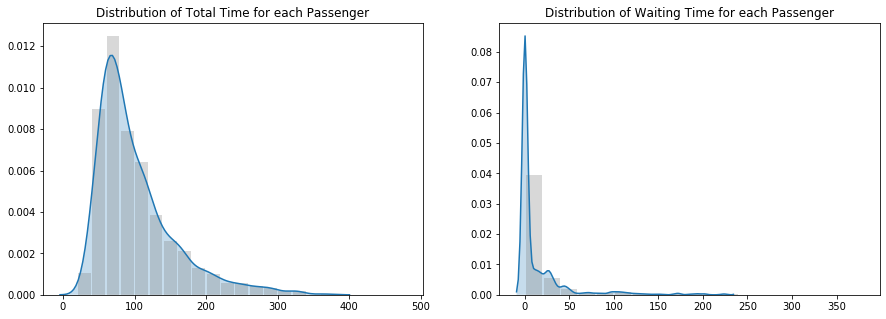

In [116]:
fig = plt.figure(figsize=(15,5))
x1 = range(0,(math.ceil(max(totaltime)/100)+1)*100,20)
x2 = range(0,(math.ceil(max(waitingtime)/100)+1)*100,20)

plt.subplot2grid((1,2),(0,0))
plt.hist(totaltime, bins=x1, rwidth=0.9, density=True, color='grey', alpha=0.3)
sns.kdeplot(totaltime, shade=True)
plt.title('Distribution of Total Time for each Passenger')

plt.subplot2grid((1,2),(0,1))
plt.hist(waitingtime, bins=x2, rwidth=0.9, density=True, color='grey', alpha=0.3)
sns.kdeplot(waitingtime, shade=True)
plt.title('Distribution of Waiting Time for each Passenger')

Then we change the average number of passengers arrives per minute to 50, while the number of servers at ID checking and the number of personal scanner checking queues are remainning 10. The situation goes bad. In the simulation trail illustrate below, 8410 passengers arrive at airport but only 1114 of them finish the whole checking process. And for the passengers who finish the process, average total time is around 73 minutes (4370 seconds) and average waiting time is around 71 minutes (4280 seconds).

Average time of security process: 4370.09
Average waiting time in the queue: 4280.03
Number of passengers arrive at airport:8410
Number of passengers finish secure check: 1114


Text(0.5, 1.0, 'Distribution of Waiting Time for each Passenger')

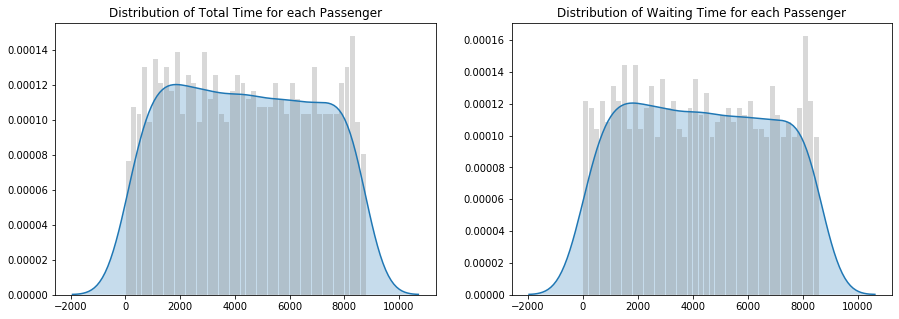

In [117]:
# key parameters we explore
PASSENGERS_PER_MINUTE = 50 # lambda 1, average number of passengers arrives per minute
NUMBER_IDCHECK = 10 # number of servers at ID checking
NUMBER_SCANNER = 10 # number of personal scanner checking queues

timestore={} # store the time point for each passenger

# Setup and start the simulation
env = simpy.Environment()
env.process(setup(env, NUMBER_IDCHECK, NUMBER_SCANNER, AVERGAE_TIME_IDCHECK, PASSENGERS_PER_MINUTE, TIME_SCANNER_LOWER, TIME_SCANNER_UPPER, INITIAL_PASSENGERS, timestore))
env.run(until=SIM_TIME)

totaltime = []
waitingtime = []
count = 0 # record how many passengers finish the secure check
for p in timestore:
    if len(timestore[p]) == 5:
        count += 1
        totaltime.append(timestore[p][4]-timestore[p][0])
        waitingtime.append(timestore[p][1]-timestore[p][0]+timestore[p][3]-timestore[p][2])

print('Average time of security process: {:.2f}'.format(sum(totaltime)/len(totaltime)))
print('Average waiting time in the queue: {:.2f}'.format(sum(waitingtime)/len(waitingtime)))
print('Number of passengers arrive at airport:{}'.format(len(timestore)))
print('Number of passengers finish secure check: {}'.format(count))

fig = plt.figure(figsize=(15,5))
x1 = range(0,(math.ceil(max(totaltime)/100)+1)*100,200)
x2 = range(0,(math.ceil(max(waitingtime)/100)+1)*100,200)

plt.subplot2grid((1,2),(0,0))
plt.hist(totaltime, bins=x1, rwidth=0.9, density=True, color='grey', alpha=0.3)
sns.kdeplot(totaltime, shade=True)
plt.title('Distribution of Total Time for each Passenger')

plt.subplot2grid((1,2),(0,1))
plt.hist(waitingtime, bins=x2, rwidth=0.9, density=True, color='grey', alpha=0.3)
sns.kdeplot(waitingtime, shade=True)
plt.title('Distribution of Waiting Time for each Passenger')

**How many security resource are needed to keep waiting time under 15 minutes?**

In the two examples above, we show two simulation trails in which the parameters are:

1). ID checking resource = 10, scanner checking resource = 10, number of average arrival per minute = 10

2). ID checking resource = 10, scanner checking resource = 10, number of average arrival per minute = 50

Under condition one, the waiting time is quite short. While as number of passengers getting larger in condition two, waiting time becomes severely long.

In this session, we will explore how many resources are needed when the number of average arrival per minute equal to 50. Because there are randomness in each simulation, run numbers of trails under one condition and calculate the average values will be more robust. Considering the time efficiency of this homework, we choose to run 5 times for one condition to demonstrate the porcess. In real simulation problem, we think the times of simulation under one condition should be far more than 5.

In [121]:
parameters = [str(num) for num in range(30,75,5)]

data_total = pd.DataFrame(index=parameters, columns=parameters)
data_waiting = pd.DataFrame(index=parameters, columns=parameters)

for a in range(len(parameters)):
    for b in range(len(parameters)):
        # key parameters we explore
        PASSENGERS_PER_MINUTE = 50 # lambda 1, average number of passengers arrives per minute
        NUMBER_IDCHECK = int(data_total.index[a]) # number of servers at ID checking
        NUMBER_SCANNER = int(data_total.columns[b]) # number of personal scanner checking queues
    
        simulationtimes = 5
    
        total = 0
        waiting = 0
    
        for c in range(simulationtimes):
            timestore={}
            env = simpy.Environment()
            env.process(setup(env, NUMBER_IDCHECK, NUMBER_SCANNER, AVERGAE_TIME_IDCHECK, PASSENGERS_PER_MINUTE, TIME_SCANNER_LOWER, TIME_SCANNER_UPPER, INITIAL_PASSENGERS, timestore))
            env.run(until=SIM_TIME)
        
            totaltime = []
            waitingtime = []
            for p in timestore:
                if len(timestore[p]) == 5:
                    totaltime.append(timestore[p][4]-timestore[p][0])
                    waitingtime.append(timestore[p][1]-timestore[p][0]+timestore[p][3]-timestore[p][2])
        
            # store the results of one simulation
            total = total + sum(totaltime)/len(totaltime)
            waiting = waiting + sum(waitingtime)/len(waitingtime)
    
        data_total.loc[data_total.index[a], data_total.columns[b]] = total/simulationtimes
        data_waiting.loc[data_total.index[a], data_total.columns[b]] = waiting/simulationtimes

Based on the heatmap, when the number of ID checking servers goes beyound 60 and the number of scanner queues is larger than 30, the average total security checking time will be less than 20 minutes if the average arriving passengers per minute equals to 50. And also, the number of ID checking servers is more like a bottleneck in the whole process. Increasing the resource in ID checking is more effective.

Text(0.5, 1, 'Heatmap of Average Total Security Checking Time (min)')

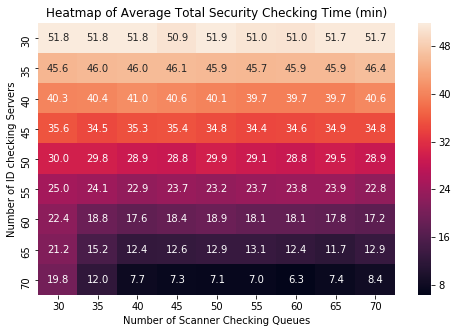

In [122]:
data_total = data_total[data_total.columns].astype(float)
data_total = data_total[data_total.columns]/60
fig=plt.figure(figsize=(8,5))
sns.heatmap(data_total, annot=True, fmt='.1f')
plt.xlabel("Number of Scanner Checking Queues")
plt.ylabel("Number of ID checking Servers")
plt.title("Heatmap of Average Total Security Checking Time (min)")

As for the total waiting time, the distribution is similar in different conditions. Approximately, when the number of ID checking servers goes beyound 60 and the number of scanner queues is larger than 35, the average waiting time will be less than 15 minutes if the average arriving passengers per minute equals to 50.

Text(0.5, 1, 'Heatmap of Average Waiting Time (min)')

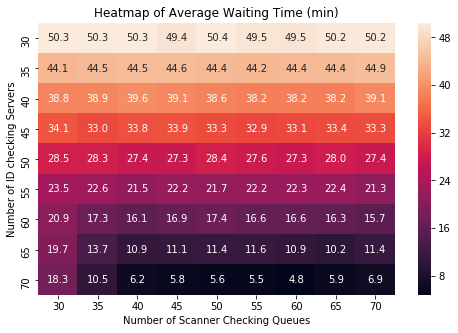

In [123]:
data_waiting = data_waiting[data_waiting.columns].astype(float)
data_waiting = data_waiting[data_waiting.columns]/60
fig=plt.figure(figsize=(8,5))
sns.heatmap(data_waiting, annot=True, fmt='.1f')
plt.xlabel("Number of Scanner Checking Queues")
plt.ylabel("Number of ID checking Servers")
plt.title("Heatmap of Average Waiting Time (min)")